<div style="display: flex; align-items: center; width: 100%;">  
  <div style="display: flex; flex-direction: column; align-items: center; justify-content: center; width: 100px; margin-right: 0px;">    
    <a href="https://risklab.ai" style="border: 0; line-height: 0.5;">
      <img src="../utils/risklab_ai.gif" width="60px" style="border: 0; margin-bottom:-10px; vertical-align: middle;"/>
    </a>
  </div>  
  <div style="flex-grow: 1;">
    <h1 style="margin: 0; margin-left:0; font-weight: bold; text-align: left; font-size: 38px;">
      Backtest Overfitting Simulation
    </h1>
  </div>  
</div>

This notebook demonstrates financial asset clustering using the `RiskLabAI` library, based on Chapter 4 of 'Advances in Financial Machine Learning' by Marcos López de Prado.

In this tutorial, we will:
1.  **Data Preparation:** Load US Treasury yield data from FRED, process it, and compute the correlation matrix.
2.  **Visualizing the Problem:** Show a heatmap of the original, unsorted correlation matrix.
3.  **Synthetic Benchmark:** Use `random_block_correlation` to create a synthetic matrix with a *known* cluster structure.
4.  **Base K-Means:** Apply the `cluster_k_means_base` algorithm to find the optimal number of clusters based on the silhouette score t-statistic.
5.  **Optimized Nested Clustering (ONC):** Apply the `cluster_k_means_top` function, which recursively re-clusters unstable groups to find a more robust solution.
6.  **Visualizing the Solution:** Show heatmaps of the sorted correlation matrices to see the clusters our algorithms uncovered.

## 0. Setup and Imports

First, we import our libraries, the necessary modules from `RiskLabAI`, and set up our plotting theme.

In [ ]:
# Standard Imports
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
from fredapi import Fred
from dotenv import load_dotenv
from pprint import pprint

# RiskLabAI Imports
import RiskLabAI.cluster.clustering as cl
import RiskLabAI.utils.publication_plots as pub_plots

# --- Global Plotting Settings ---
SAVE_PLOTS = True
PLOT_THEME = 'dark' # Options: 'light', 'medium'. 'dark', 'light-transparent'
PLOT_QUALITY = 300
SAVE_DIR = 'figs'

pub_plots.setup_publication_style(
    theme=PLOT_THEME,
    quality=PLOT_QUALITY,
    save_plots=SAVE_PLOTS,
    save_dir=SAVE_DIR
)

Matplotlib style updated. Theme: 'dark', Quality: 300 DPI.
Plot saving disabled.


## 1. Load and Prepare Data

We will load daily yield data for a set of US Treasuries from the FRED database. To analyze their relationships, we must first convert the absolute yields to **daily changes** (first difference).

From these yield changes, we compute the Pearson correlation matrix, which will be the input for our clustering algorithms.

In [ ]:
# --- 1. Set up FRED API Key ---

# This finds the .env file and loads FRED_API_KEY into os.environ
load_dotenv()

# To run the code on your computer, register for a free FRED API key and
# uncomment the following line, replacing 'YOUR_FRED_API_KEY'

# FRED_API_KEY = 'YOUR_FRED_API_KEY'

# --- 2. Check if API key is available ---
if 'FRED_API_KEY' not in locals() and 'FRED_API_KEY' not in os.environ:
    print("Error: FRED_API_KEY not set.")
    print("Please uncomment the line above or set it in your .env file.")
    
    # Create a dummy dataframe to allow notebook to run
    n_dummy = 12
    dummy_data = cl.random_block_correlation(n_dummy, 4, random_state=42)
    # Give dummy columns names
    dummy_data.columns = [f"DUMMY_{i}" for i in range(n_dummy)]
    dummy_data.index = [f"DUMMY_{i}" for i in range(n_dummy)]
    corr_matrix = dummy_data
    print(f"Using synthetic dummy {n_dummy}x{n_dummy} correlation matrix for demonstration.")

else:
    # Get the key from either the local variable or the environment
    API_KEY = locals().get('FRED_API_KEY', os.environ.get('FRED_API_KEY'))
    fred = Fred(api_key=API_KEY)
    print("FRED API Key loaded successfully.")

    # --- 3. Define Treasury Yield Tickers ---
    # We will use a range of US Treasury yields (bills, notes, bonds)
    yield_tickers = {
        "DGS3MO": "3-Month Treasury",
        "DGS6MO": "6-Month Treasury",
        "DGS1": "1-Year Treasury",
        "DGS2": "2-Year Treasury",
        "DGS3": "3-Year Treasury",
        "DGS5": "5-Year Treasury",
        "DGS7": "7-Year Treasury",
        "DGS10": "10-Year Treasury",
        "DGS20": "20-Year Treasury",
        "DGS30": "30-Year Treasury",
        "T10Y2Y": "10Y-2Y Spread",
        "T10Y3M": "10Y-3M Spread"
    }
    
    # --- 4. Download and Process Data ---
    all_yields = pd.DataFrame()
    for ticker, name in yield_tickers.items():
        print(f"Downloading: {name} ({ticker})")
        series = fred.get_series(ticker, start="2010-01-01", end="2023-01-01")
        series = series.rename(name) # Use friendly names
        all_yields = pd.concat([all_yields, series], axis=1)
    
    # Data Cleaning
    all_yields = all_yields.dropna() # Drop rows with any missing data
    
    if all_yields.empty:
        print("Error: No data downloaded. Check API key or tickers.")
        n_dummy = len(yield_tickers)
        dummy_data = cl.random_block_correlation(n_dummy, 4, random_state=42)
        dummy_data.columns = yield_tickers.values()
        dummy_data.index = yield_tickers.values()
        corr_matrix = dummy_data
        print(f"Using synthetic dummy {n_dummy}x{n_dummy} correlation matrix for demonstration.")
    else:
        print(f"\nSuccessfully downloaded and processed {all_yields.shape[0]} observations.")
        
        # --- 5. Compute Correlation Matrix ---
        # For yields, we analyze the correlation of *daily changes* (first difference)
        # not percentage returns or raw values.
        yield_changes = all_yields.diff().dropna()
        corr_matrix = yield_changes.corr()

        print("\nCorrelation Matrix:")
        display(corr_matrix.head())

FRED API Key loaded successfully.
Downloading: 3-Month Treasury (DGS3MO)
Downloading: 6-Month Treasury (DGS6MO)
Downloading: 1-Year Treasury (DGS1)
Downloading: 2-Year Treasury (DGS2)
Downloading: 3-Year Treasury (DGS3)
Downloading: 5-Year Treasury (DGS5)
Downloading: 7-Year Treasury (DGS7)
Downloading: 10-Year Treasury (DGS10)
Downloading: 20-Year Treasury (DGS20)
Downloading: 30-Year Treasury (DGS30)
Downloading: 10Y-2Y Spread (T10Y2Y)
Downloading: 10Y-3M Spread (T10Y3M)

Successfully downloaded and processed 9280 observations.

Correlation Matrix:


,3-Month Treasury,6-Month Treasury,1-Year Treasury,2-Year Treasury,3-Year Treasury,5-Year Treasury,7-Year Treasury,10-Year Treasury,20-Year Treasury,30-Year Treasury,10Y-2Y Spread,10Y-3M Spread
3-Month Treasury,1.000000,0.826816,0.737370,0.583345,0.541270,0.482358,0.446697,0.429205,0.371997,0.378397,-0.284706,-0.597055
6-Month Treasury,0.826816,1.000000,0.893113,0.742222,0.695677,0.635208,0.593873,0.573501,0.506609,0.505795,-0.316191,-0.299293
1-Year Treasury,0.737370,0.893113,1.000000,0.879571,0.838648,0.779153,0.733336,0.706124,0.627424,0.613672,-0.330174,-0.094356
2-Year Treasury,0.583345,0.742222,0.879571,1.000000,0.951021,0.909222,0.863943,0.827902,0.736264,0.707883,-0.333184,0.164469
3-Year Treasury,0.541270,0.695677,0.838648,0.951021,1.000000,0.951587,0.914150,0.881779,0.793482,0.763546,-0.158126,0.253414


## 2. Visualizing the Problem

Let's plot a heatmap of the raw correlation matrix. It's difficult to see any clear, defined clusters. The assets are sorted by ticker name (or the order we downloaded them), so correlated assets are not necessarily grouped.

The goal of clustering is to re-order this matrix to reveal the hidden block structures.

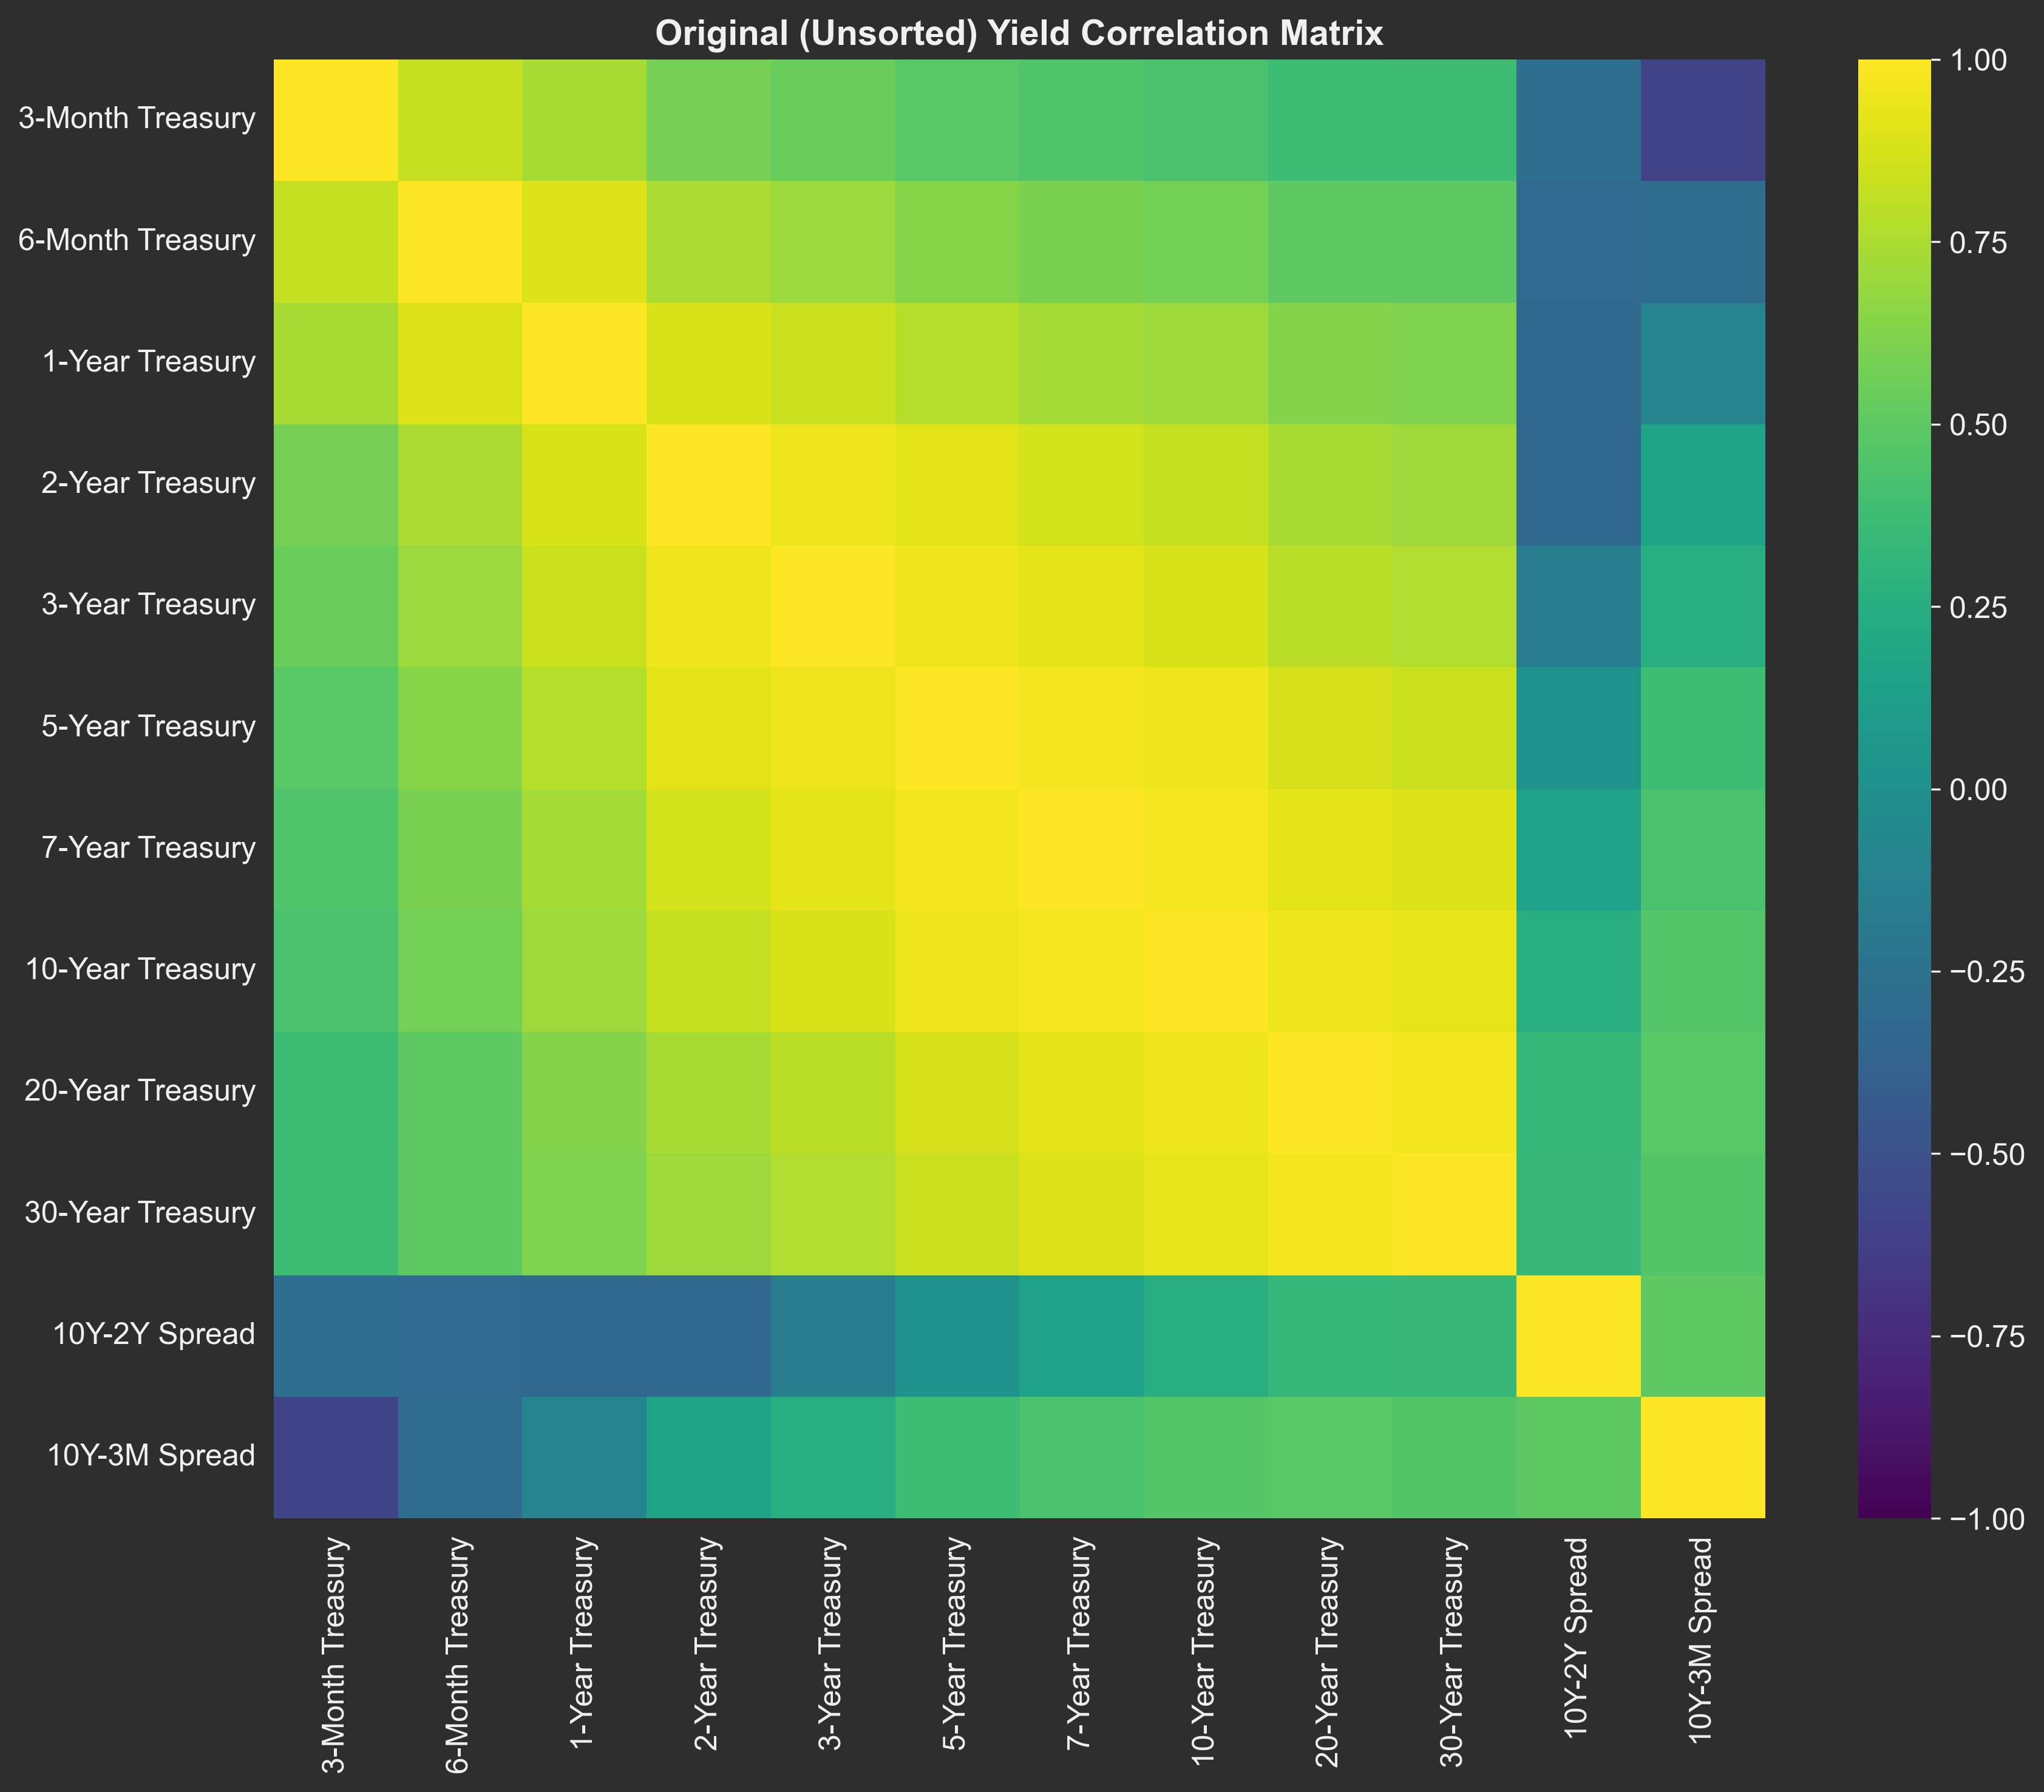

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, ax=ax, cmap='viridis', vmin=-1, vmax=1)
pub_plots.apply_plot_style(ax, 'Original (Unsorted) Yield Correlation Matrix', '', '')
plt.tight_layout()
pub_plots.finalize_plot(fig, 'unsorted_corr.png')

## 3. Synthetic Data Benchmark

Before we cluster the real data, let's see what a "perfect" result would look like. We use `random_block_correlation` to generate a synthetic matrix with **4 known blocks** plus a market component.

This is our target. We want our clustering algorithm to find and re-order the real matrix to look like this.

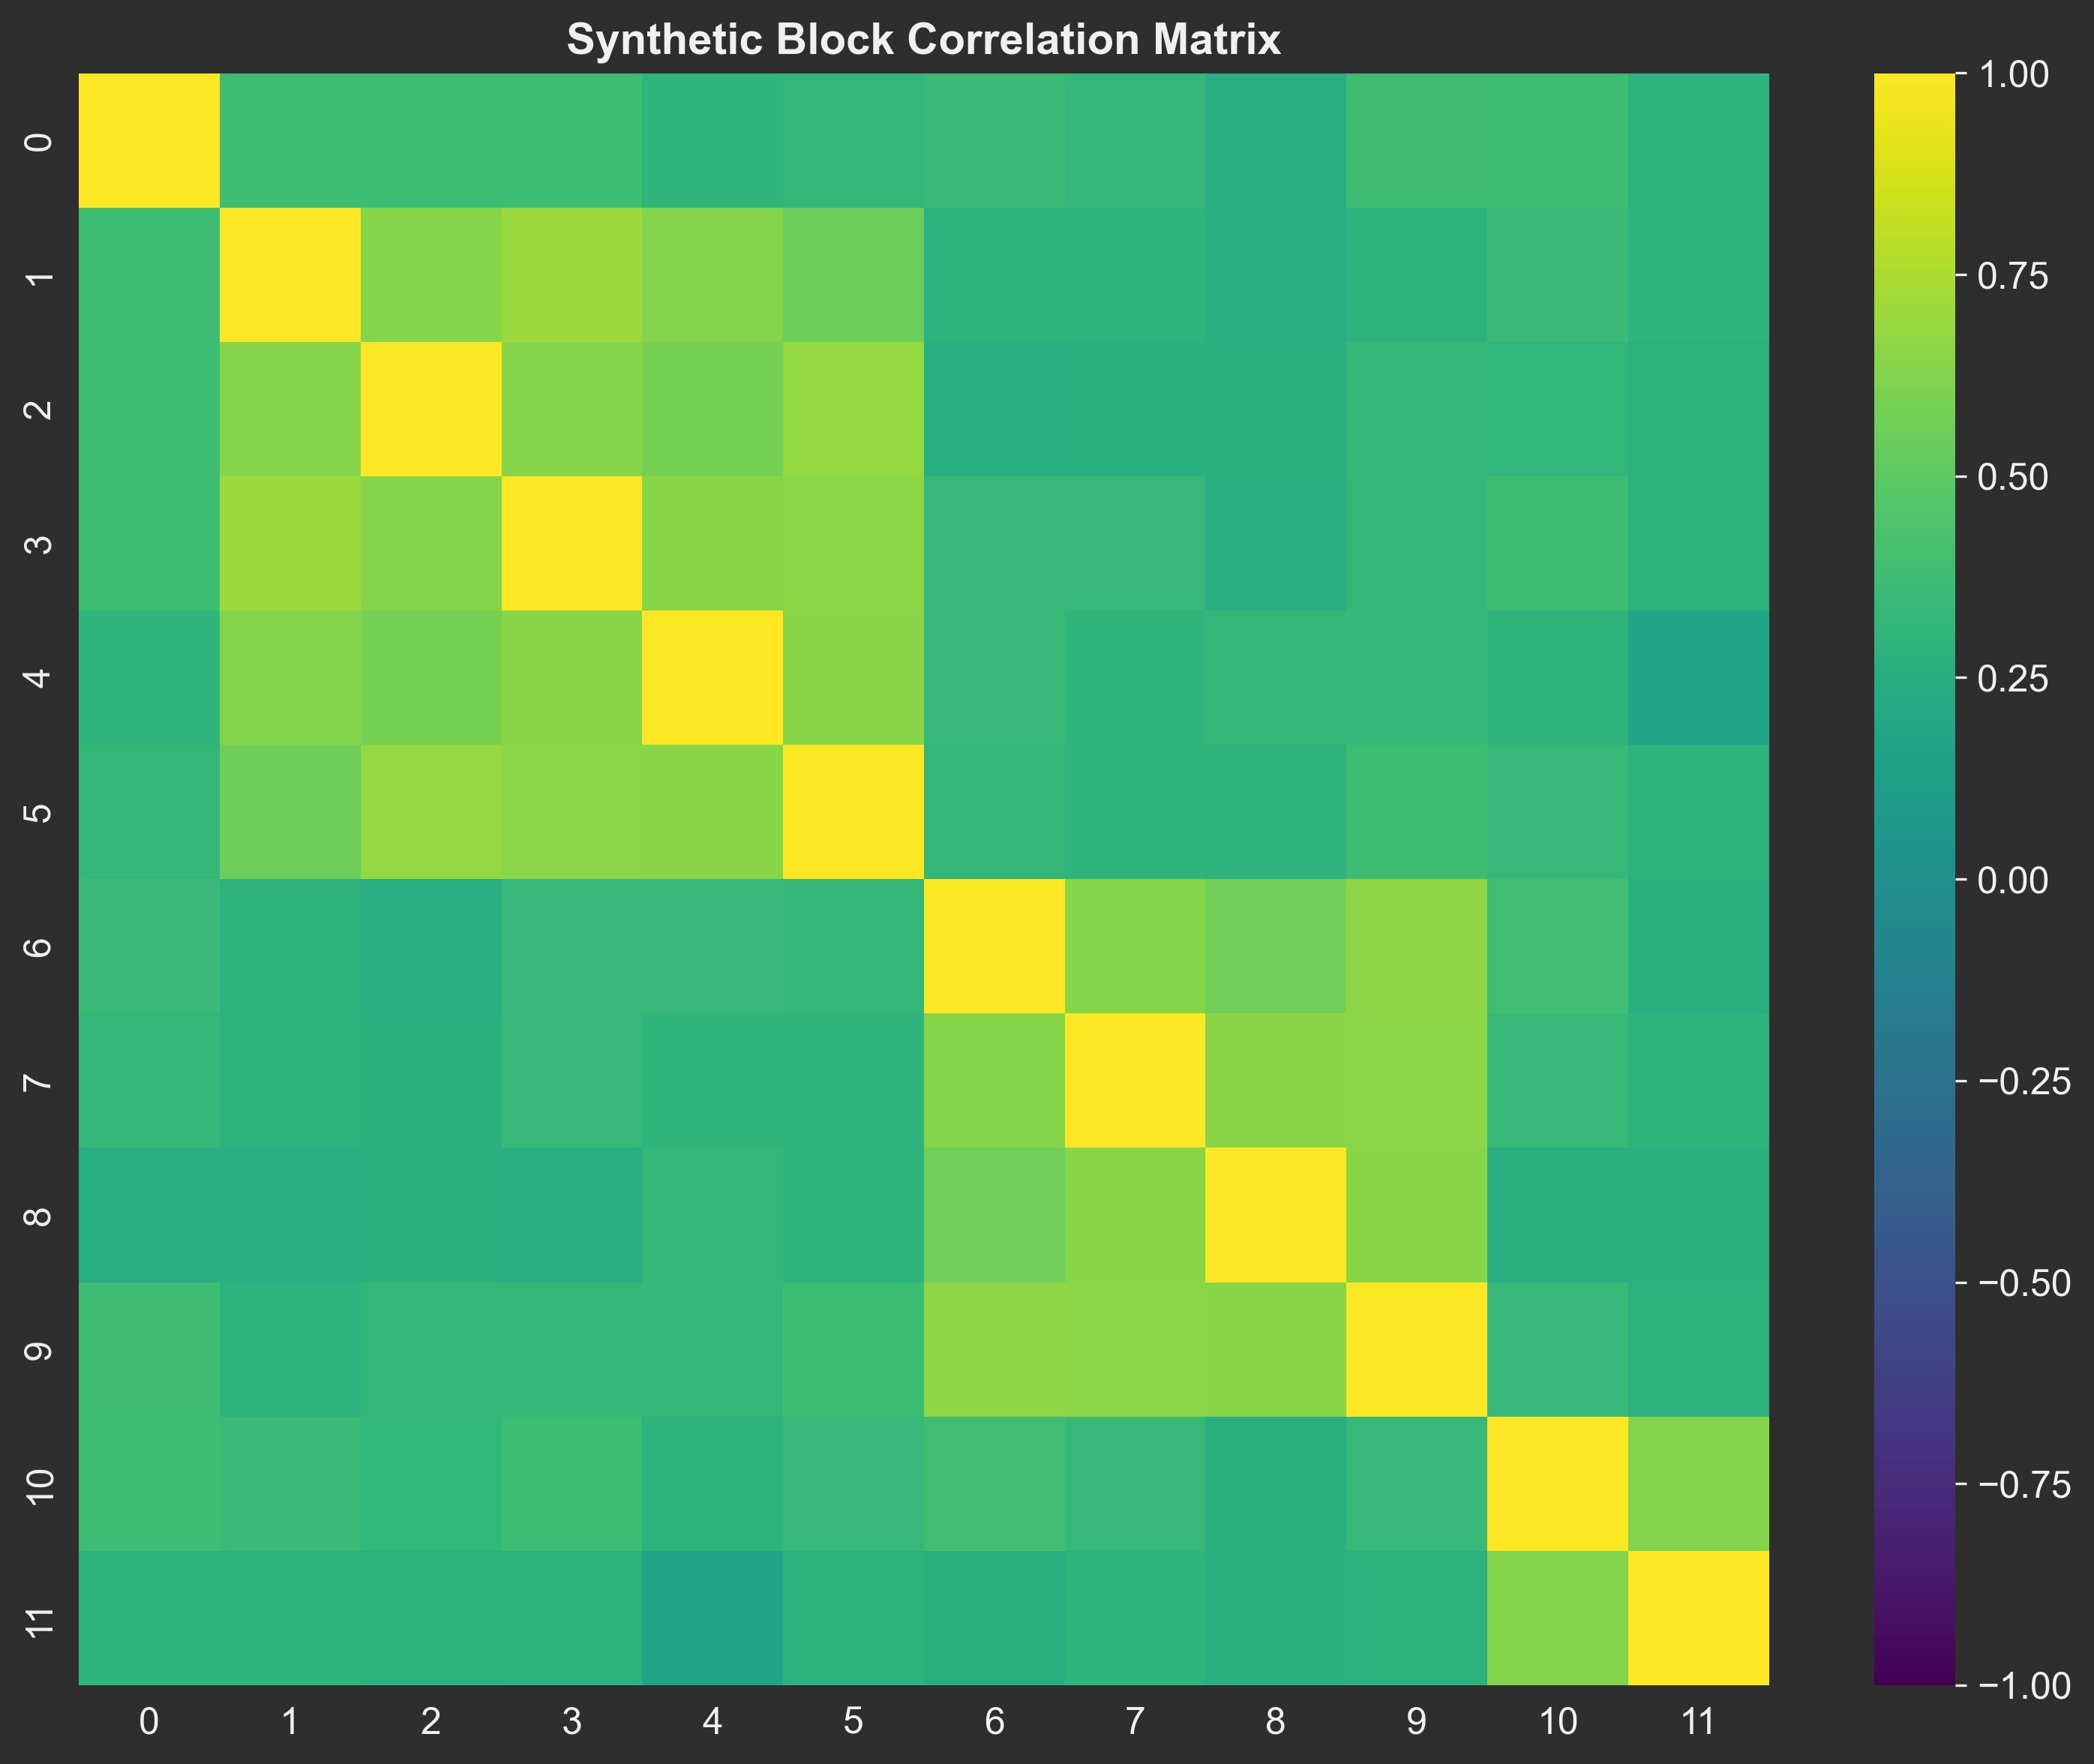

In [ ]:
# Generate a synthetic correlation matrix with a known structure
# Match the number of columns from our real data
synth_corr = cl.random_block_correlation(
    n_columns=corr_matrix.shape[0], 
    n_blocks=4, 
    random_state=42
)

# Plot the synthetic matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(synth_corr, ax=ax, cmap='viridis', vmin=-1, vmax=1)
pub_plots.apply_plot_style(ax, 'Synthetic Block Correlation Matrix', '', '')
plt.tight_layout()
pub_plots.finalize_plot(fig, 'synthetic_corr.png')

## 4. Base K-Means Clustering

The `cluster_k_means_base` function is the first step. It runs K-Means multiple times for different numbers of clusters (k) and uses the **t-statistic of the silhouette scores** to determine the optimal `k`.

It returns the sorted matrix, the cluster assignments, and the silhouette scores for each asset.

In [ ]:
corr_sorted_base, clusters_base, silh_base = cl.cluster_k_means_base(
    corr_matrix,
    max_clusters=10, 
    iterations=10,
    random_state=42
)

print(f"Found {len(clusters_base)} clusters with base K-Means:")
pprint(clusters_base)

Found 2 clusters with base K-Means:
{np.int32(0): ['3-Month Treasury',
               '6-Month Treasury',
               '1-Year Treasury',
               '2-Year Treasury',
               '3-Year Treasury',
               '5-Year Treasury',
               '7-Year Treasury',
               '10-Year Treasury',
               '20-Year Treasury',
               '30-Year Treasury'],
 np.int32(1): ['10Y-2Y Spread', '10Y-3M Spread']}


Now, let's plot the heatmap of the matrix sorted by these base clusters. It's much better, but you can see some "noisy" assets within the blocks.

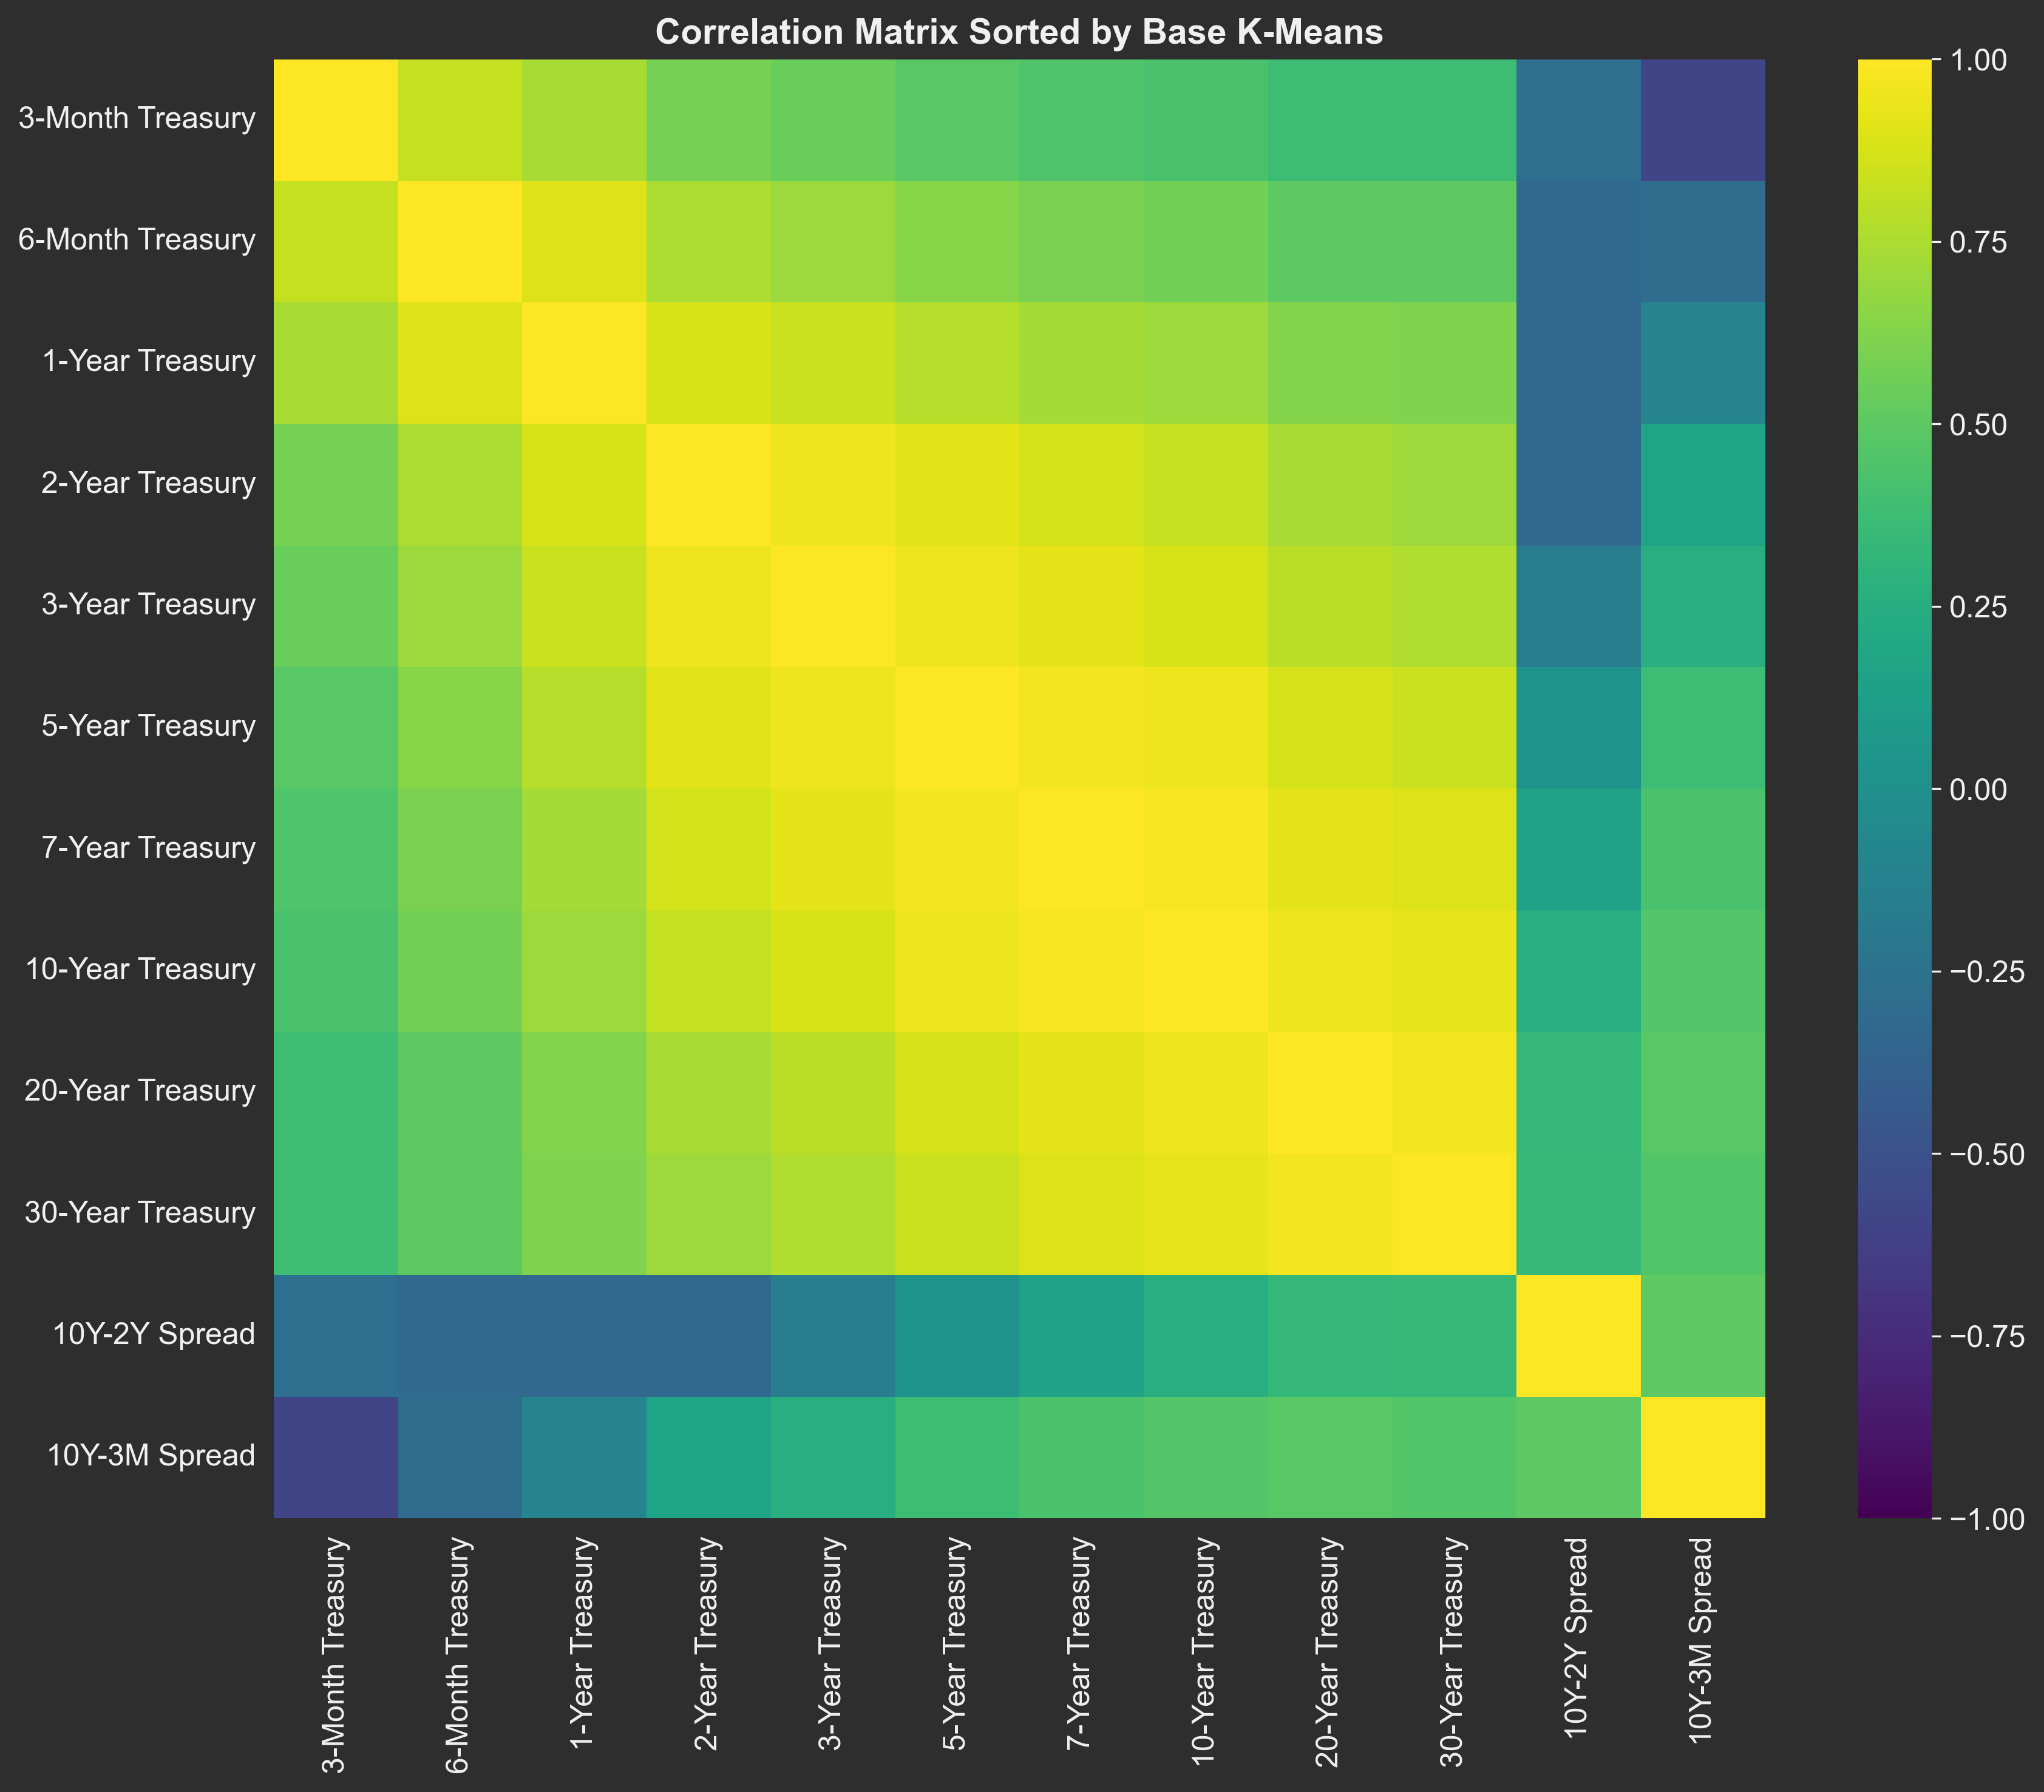

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_sorted_base, ax=ax, cmap='viridis', vmin=-1, vmax=1)
pub_plots.apply_plot_style(ax, 'Correlation Matrix Sorted by Base K-Means', '', '')
plt.tight_layout()
pub_plots.finalize_plot(fig, 'base_kmeans_corr.png')

## 5. Optimized Nested Clustering (ONC)

The `cluster_k_means_top` function implements the full **Optimized Nested Clustering (ONC)** algorithm. 

It works by:
1. Running `cluster_k_means_base` (as we did above).
2. Identifying "unstable" clusters (those with a silhouette t-stat below the average).
3. Taking all unstable clusters, grouping them together, and **re-clustering them recursively**.
4. Merging the stable clusters with the new sub-clusters.

This recursive process results in more stable and homogeneous clusters.

In [ ]:
corr_sorted_onc, clusters_onc, silh_onc = cl.cluster_k_means_top(
    corr_matrix, 
    max_clusters=10, 
    iterations=10,
    random_state=42
)

print(f"Found {len(clusters_onc)} clusters with Optimized Nested Clustering (ONC):")
pprint(clusters_onc)

Found 2 clusters with Optimized Nested Clustering (ONC):
{np.int32(0): ['3-Month Treasury',
               '6-Month Treasury',
               '1-Year Treasury',
               '2-Year Treasury',
               '3-Year Treasury',
               '5-Year Treasury',
               '7-Year Treasury',
               '10-Year Treasury',
               '20-Year Treasury',
               '30-Year Treasury'],
 np.int32(1): ['10Y-2Y Spread', '10Y-3M Spread']}


Let's plot the final heatmap. The resulting clusters are tighter and make more intuitive sense. For example, the short-term yields (3M, 6M, 1Y) are likely grouped, the long-term yields (10Y, 20Y, 30Y) are grouped, and the yield-spreads (10Y-2Y) are often isolated into their own cluster.

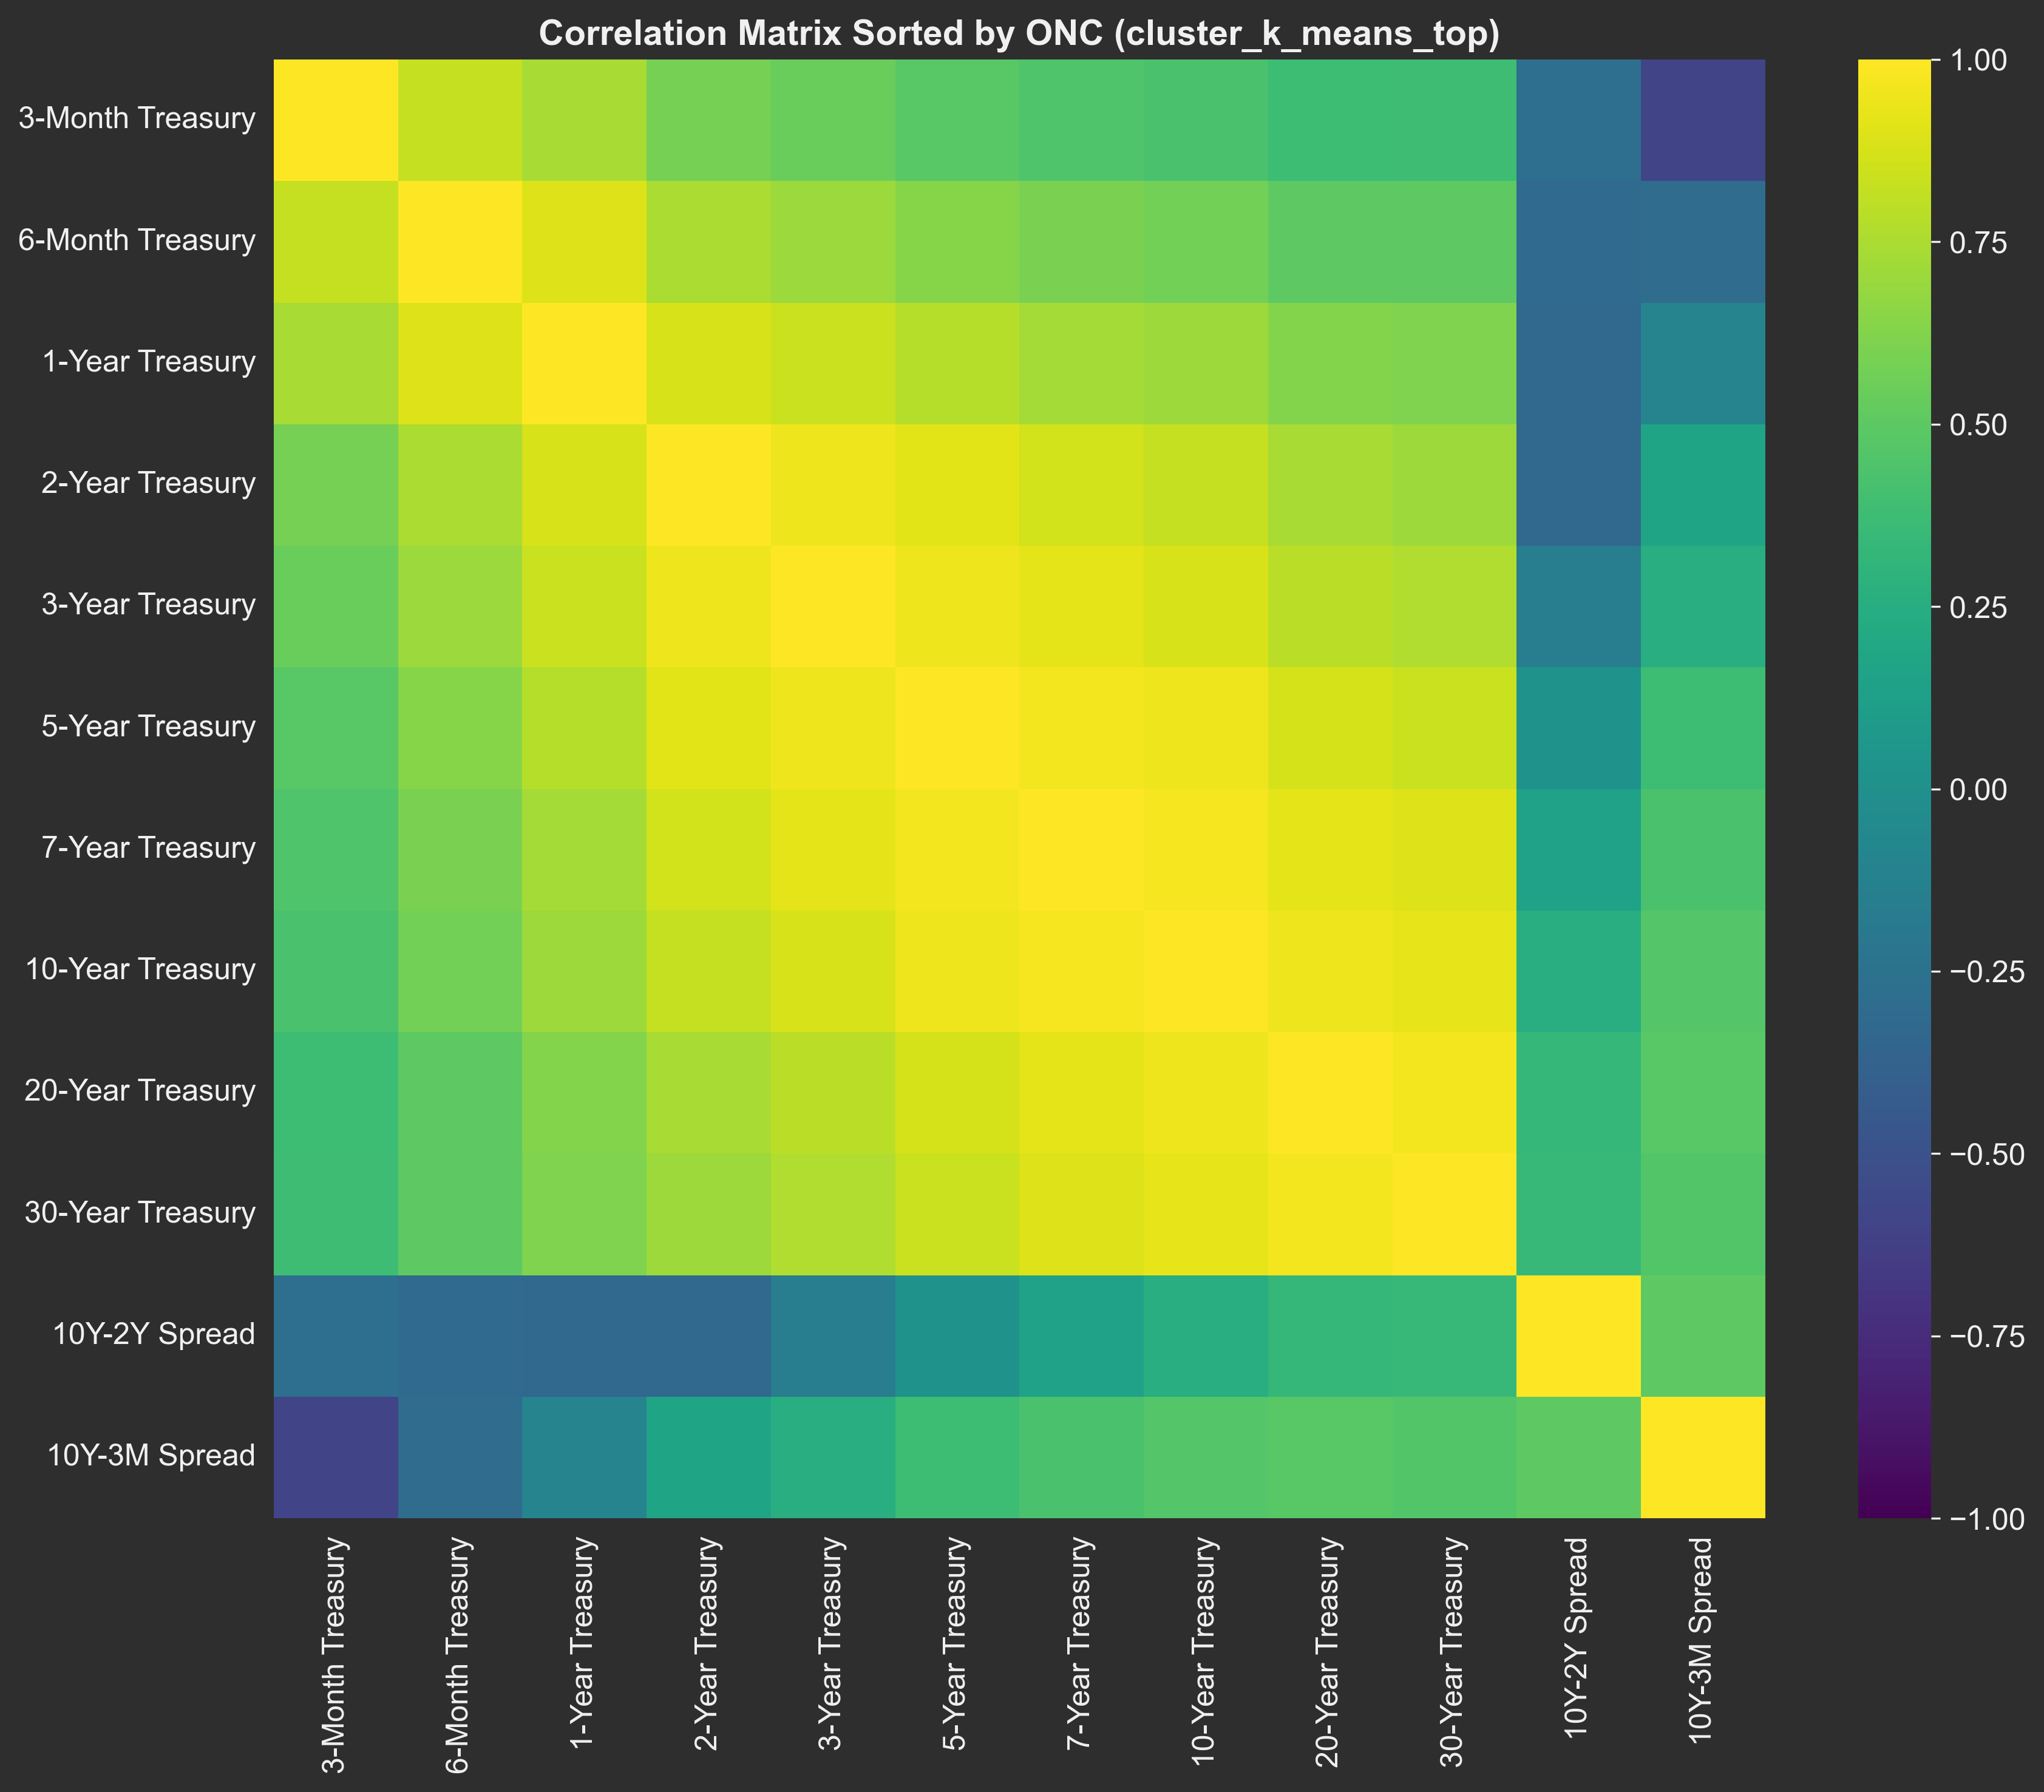

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_sorted_onc, ax=ax, cmap='viridis', vmin=-1, vmax=1)
pub_plots.apply_plot_style(ax, 'Correlation Matrix Sorted by ONC (cluster_k_means_top)', '', '')
plt.tight_layout()
pub_plots.finalize_plot(fig, 'onc_corr.png')